# 네이버 영화 리뷰 감성 분석

### 1. 라이브러리 임포트 및 환경 변수 설정
- 데이터 처리에 필요한 라이브러리 임포트
- **Mecab 경로 문제 해결**: `konlpy`가 Apple Silicon(M1/M2/M3) 환경의 Homebrew 경로를 올바르게 찾을 수 있도록, `MECABRC` 환경 변수를 설정하여 `mecabrc` 파일의 위치를 직접 지정

In [14]:
import pandas as pd
import numpy as np
from collections import Counter
from konlpy.tag import Mecab
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False   # 마이너스(-) 깨짐 방지

# MPS 장치 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


### 2. 데이터 로드 및 전처리 함수 정의
- `ratings_train.txt`와 `ratings_test.txt` 파일 로드
- 데이터 정제, 토큰화, 단어 사전 구축, 인코딩을 한 번에 수행하는 `load_data` 함수 정의

In [15]:
train_data = pd.read_table('data/rating_train.txt')
test_data = pd.read_table('data/ratings_test.txt')

# Mecab 형태소 분석기 초기화
tokenizer = Mecab(dicpath='/opt/homebrew/lib/mecab/dic/mecab-ko-dic')
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 텍스트 정제 (한글, 공백 제외 모두 제거)
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    train_data['document'] = train_data['document'].str.replace('^ +', "")
    test_data['document'] = test_data['document'].str.replace('^ +', "")
    train_data['document'].replace('', np.nan, inplace=True)
    test_data['document'].replace('', np.nan, inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

print("데이터 전처리 완료!")
print(f"훈련 샘플 개수: {len(X_train)}, 테스트 샘플 개수: {len(X_test)}")

/var/folders/14/wm3n_r1s01jfgw6n8j7pr4740000gn/T/ipykernel_88173/1934434669.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document'].replace('', np.nan, inplace=True)
/var/folders/14/wm3n_r1s01jfgw6n8j7pr4740000gn/T/ipykernel_88173/1934434669.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

데이터 전처리 완료!
훈련 샘플 개수: 149995, 테스트 샘플 개수: 49997


In [16]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

문장길이 평균 :  15.661001440057602
문장길이 최대 :  116
문장길이 표준편차 :  12.86005928517247
pad_sequences maxlen : 41
전체 문장의 0.9323%가 maxlen 설정값 이내에 포함됩니다.


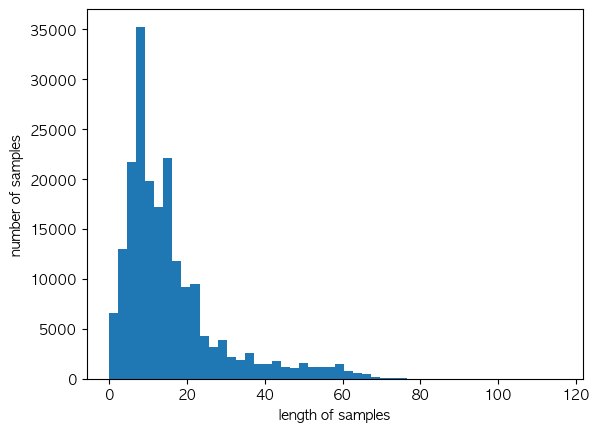

In [17]:
import matplotlib.pyplot as plt

# 1. 문장 길이 분포 확인
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 2. 적절한 maxlen 설정
# 예: (평균 + 2*표준편차) 내에 대부분의 데이터가 포함될 것
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'pad_sequences maxlen : {maxlen}')
print(f'전체 문장의 {np.sum(num_tokens < maxlen) / len(num_tokens):.4f}%가 maxlen 설정값 이내에 포함됩니다.')

# 3. 문장 길이 분포 시각화
plt.hist(num_tokens, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
# Keras의 pad_sequences와 동일한 기능의 함수 구현
def pad_sequences(sequences, maxlen, padding='post', truncating='post', value=0):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > maxlen:
            if truncating == 'post':
                padded_sequences.append(seq[:maxlen])
            else: # 'pre'
                padded_sequences.append(seq[-maxlen:])
        else:
            if padding == 'post':
                padded_sequences.append(seq + [value] * (maxlen - len(seq)))
            else: # 'pre'
                padded_sequences.append([value] * (maxlen - len(seq)) + seq)
    return np.array(padded_sequences)

# 패딩 적용
X_train_padded = pad_sequences(X_train, maxlen=maxlen, padding='pre', truncating='pre', value=0)
X_test_padded = pad_sequences(X_test, maxlen=maxlen, padding='pre', truncating='pre', value=0)
print("패딩 적용 후 훈련 데이터 shape:", X_train_padded.shape)
print("패딩 적용 후 테스트 데이터 shape:", X_test_padded.shape)

패딩 적용 후 훈련 데이터 shape: (149995, 41)
패딩 적용 후 테스트 데이터 shape: (49997, 41)


### 4. PyTorch 모델 구성을 위한 데이터 준비
- **데이터셋 분리**: 훈련 데이터를 훈련용과 검증용으로 나눕니다.
- **PyTorch 라이브러리 임포트**: `torch`, `torch.nn`, `DataLoader` 등 모델링에 필요한 주요 라이브러리 임포트
- **데이터 로더 생성**: 훈련, 검증, 테스트 데이터를 배치 단위로 효율적으로 처리하기 위해 `DataLoader`를 생성

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 데이터셋 분리
val_size = 40000
X_val = X_train_padded[:val_size]
y_val = y_train[:val_size]
X_train_final = X_train_padded[val_size:]
y_train_final = y_train[val_size:]

# NumPy 배열을 PyTorch 텐서로 변환
train_data = TensorDataset(torch.from_numpy(X_train_final), torch.from_numpy(y_train_final))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test_padded), torch.from_numpy(y_test))

# 데이터 로더 생성
batch_size = 512
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

print(f'훈련 데이터셋 크기: {len(train_data)}')
print(f'검증 데이터셋 크기: {len(val_data)}')
print(f'테스트 데이터셋 크기: {len(test_data)}')

훈련 데이터셋 크기: 109995
검증 데이터셋 크기: 40000
테스트 데이터셋 크기: 49997


### 5. PyTorch 모델 설계 및 학습
- **세 가지 모델 아키텍처**: `LSTM`, `1D CNN`, `GlobalMaxPooling1D`를 사용하여 각각 PyTorch 모델을 설계합니다.
- **학습 및 평가 함수**: 모델 학습과 평가를 위한 헬퍼 함수를 정의합니다.
- **실행**: 각 모델을 20 에포크 동안 학습하고, 테스트 데이터셋으로 성능을 비교 분석합니다.

In [20]:
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        hidden = lstm_out[:, -1, :]
        out = self.fc(hidden)
        return self.sigmoid(out)


In [21]:
# 1D CNN 모델 정의
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, 16, kernel_size=7)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x).permute(0, 2, 1)
        conved = torch.relu(self.conv(embedded))
        pooled = self.pool(conved).squeeze(2)
        out = self.fc(pooled)
        return self.sigmoid(out)


In [22]:
# Global Max Pooling 모델 정의
class GlobalMaxPoolingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x).permute(0, 2, 1)
        pooled = self.pool(embedded).squeeze(2)
        out = self.fc(pooled)
        return self.sigmoid(out)

In [23]:
# 하이퍼파라미터
vocab_size = 10000
embedding_dim = 16
hidden_dim = 8
output_dim = 1
num_epochs = 20

--- LSTM 모델 학습 및 평가 ---
Epoch [1/20], Loss: 0.6813, Val Accuracy: 0.6411
Epoch [2/20], Loss: 0.5603, Val Accuracy: 0.7598
Epoch [3/20], Loss: 0.4718, Val Accuracy: 0.7916
Epoch [4/20], Loss: 0.4249, Val Accuracy: 0.8101
Epoch [5/20], Loss: 0.3950, Val Accuracy: 0.8214
Epoch [6/20], Loss: 0.3742, Val Accuracy: 0.8282
Epoch [7/20], Loss: 0.3585, Val Accuracy: 0.8336
Epoch [8/20], Loss: 0.3458, Val Accuracy: 0.8371
Epoch [9/20], Loss: 0.3354, Val Accuracy: 0.8389
Epoch [10/20], Loss: 0.3266, Val Accuracy: 0.8427
Epoch [11/20], Loss: 0.3188, Val Accuracy: 0.8436
Epoch [12/20], Loss: 0.3119, Val Accuracy: 0.8460
Epoch [13/20], Loss: 0.3056, Val Accuracy: 0.8469
Epoch [14/20], Loss: 0.2998, Val Accuracy: 0.8472
Epoch [15/20], Loss: 0.2943, Val Accuracy: 0.8477
Epoch [16/20], Loss: 0.2897, Val Accuracy: 0.8487
Epoch [17/20], Loss: 0.2849, Val Accuracy: 0.8495
Epoch [18/20], Loss: 0.2807, Val Accuracy: 0.8492
Epoch [19/20], Loss: 0.2768, Val Accuracy: 0.8494
Epoch [20/20], Loss: 0.2727, Val Ac

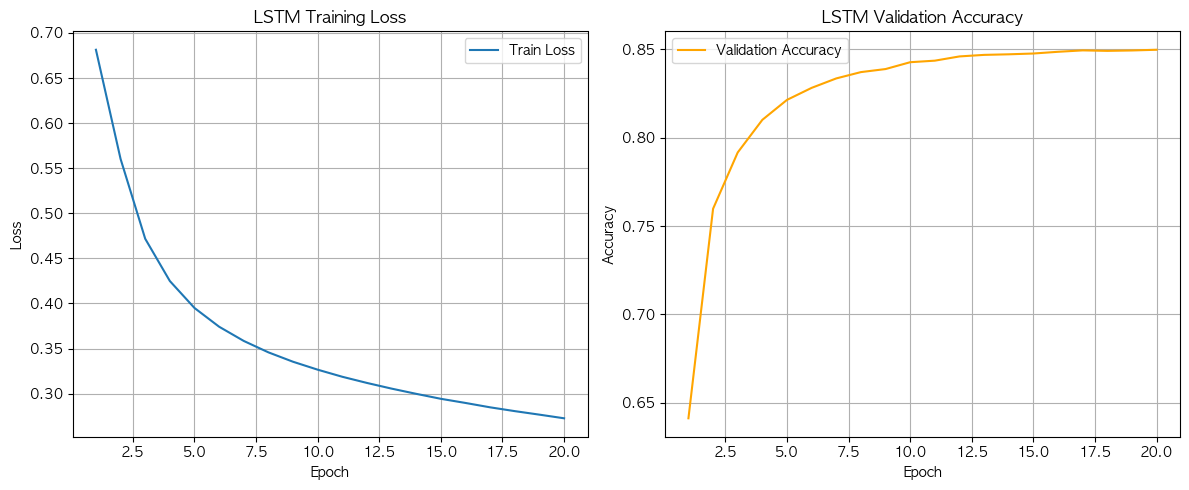

--- 1D_CNN 모델 학습 및 평가 ---
Epoch [1/20], Loss: 0.6707, Val Accuracy: 0.6516
Epoch [2/20], Loss: 0.5626, Val Accuracy: 0.7434
Epoch [3/20], Loss: 0.4752, Val Accuracy: 0.7796
Epoch [4/20], Loss: 0.4296, Val Accuracy: 0.7976
Epoch [5/20], Loss: 0.3996, Val Accuracy: 0.8096
Epoch [6/20], Loss: 0.3781, Val Accuracy: 0.8181
Epoch [7/20], Loss: 0.3614, Val Accuracy: 0.8235
Epoch [8/20], Loss: 0.3477, Val Accuracy: 0.8271
Epoch [9/20], Loss: 0.3362, Val Accuracy: 0.8313
Epoch [10/20], Loss: 0.3262, Val Accuracy: 0.8339
Epoch [11/20], Loss: 0.3176, Val Accuracy: 0.8351
Epoch [12/20], Loss: 0.3099, Val Accuracy: 0.8369
Epoch [13/20], Loss: 0.3025, Val Accuracy: 0.8372
Epoch [14/20], Loss: 0.2958, Val Accuracy: 0.8383
Epoch [15/20], Loss: 0.2898, Val Accuracy: 0.8387
Epoch [16/20], Loss: 0.2840, Val Accuracy: 0.8396
Epoch [17/20], Loss: 0.2787, Val Accuracy: 0.8403
Epoch [18/20], Loss: 0.2732, Val Accuracy: 0.8389
Epoch [19/20], Loss: 0.2685, Val Accuracy: 0.8401
Epoch [20/20], Loss: 0.2637, Val 

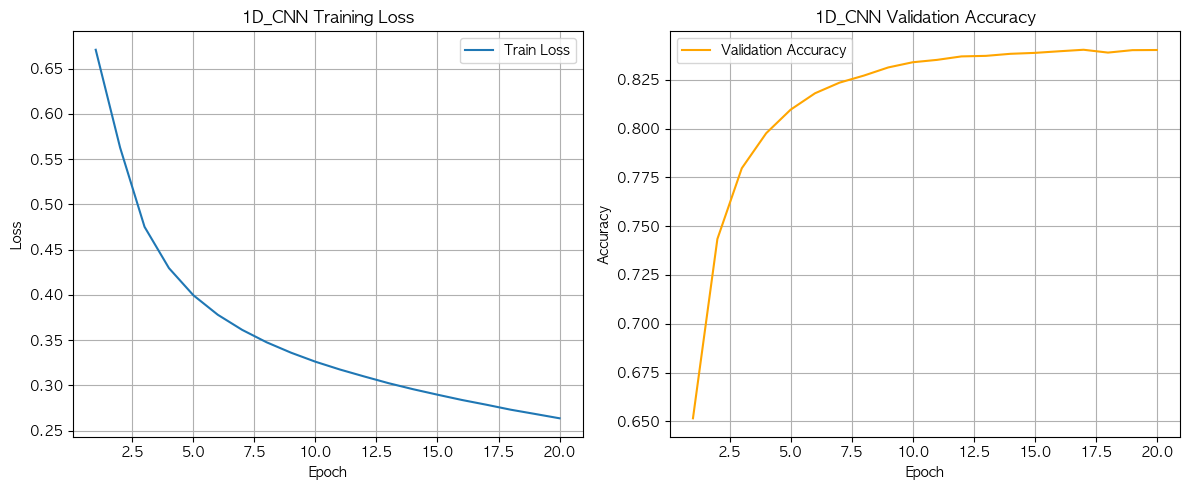

--- GlobalMaxPooling 모델 학습 및 평가 ---
Epoch [1/20], Loss: 0.6877, Val Accuracy: 0.5913
Epoch [2/20], Loss: 0.6571, Val Accuracy: 0.6421
Epoch [3/20], Loss: 0.6157, Val Accuracy: 0.6892
Epoch [4/20], Loss: 0.5684, Val Accuracy: 0.7238
Epoch [5/20], Loss: 0.5267, Val Accuracy: 0.7462
Epoch [6/20], Loss: 0.4936, Val Accuracy: 0.7652
Epoch [7/20], Loss: 0.4677, Val Accuracy: 0.7759
Epoch [8/20], Loss: 0.4475, Val Accuracy: 0.7848
Epoch [9/20], Loss: 0.4313, Val Accuracy: 0.7930
Epoch [10/20], Loss: 0.4181, Val Accuracy: 0.7993
Epoch [11/20], Loss: 0.4072, Val Accuracy: 0.8030
Epoch [12/20], Loss: 0.3979, Val Accuracy: 0.8070
Epoch [13/20], Loss: 0.3898, Val Accuracy: 0.8100
Epoch [14/20], Loss: 0.3826, Val Accuracy: 0.8124
Epoch [15/20], Loss: 0.3762, Val Accuracy: 0.8144
Epoch [16/20], Loss: 0.3704, Val Accuracy: 0.8164
Epoch [17/20], Loss: 0.3651, Val Accuracy: 0.8190
Epoch [18/20], Loss: 0.3602, Val Accuracy: 0.8204
Epoch [19/20], Loss: 0.3557, Val Accuracy: 0.8215
Epoch [20/20], Loss: 0.

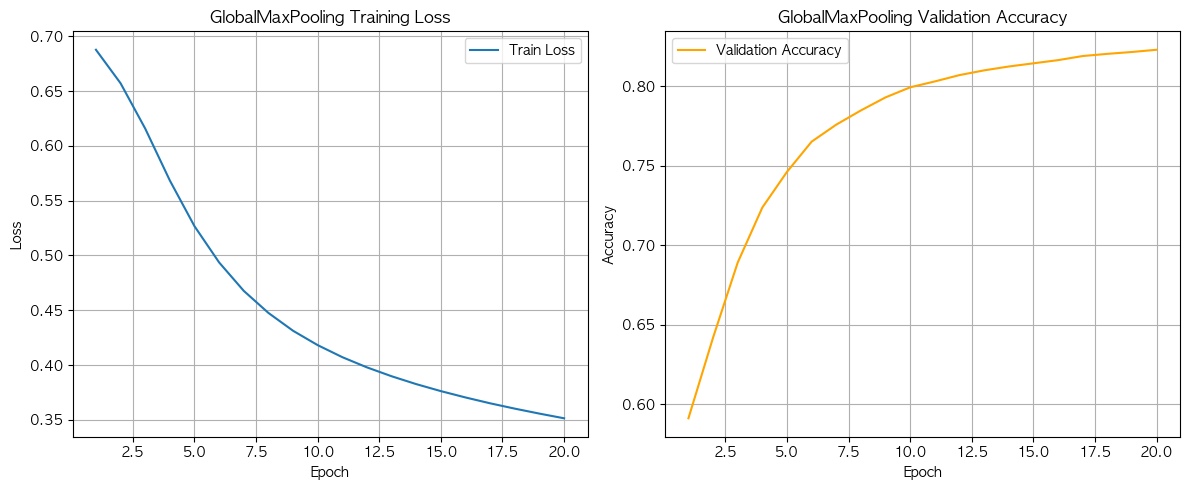

--- 최종 모델 성능 비교 ---
LSTM: 0.8454
1D_CNN: 0.8384
GlobalMaxPooling: 0.8197


In [24]:
# 학습 및 평가 함수
def train_and_evaluate(model, train_loader, val_loader, test_loader, num_epochs, device):
    model = model.to(device)  # 모델을 MPS 장치로 이동
    criterion = nn.BCELoss().to(device)  # 손실 함수를 MPS 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Loss와 Accuracy 기록
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, dtype=torch.int64), labels.to(device, dtype=torch.float32)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # 평균 손실 기록
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 검증 데이터로 정확도 계산
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, dtype=torch.int64), labels.to(device, dtype=torch.float32)
                outputs = model(inputs).squeeze()
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # 테스트 데이터로 최종 정확도 계산
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, dtype=torch.int64), labels.to(device, dtype=torch.float32)
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total

    return test_accuracy, train_losses, val_accuracies, model.embedding.weight.cpu().detach().numpy()

# 모델 실행 및 시각화
models = {
    'LSTM': LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim),
    '1D_CNN': CNNModel(vocab_size, embedding_dim, output_dim),
    'GlobalMaxPooling': GlobalMaxPoolingModel(vocab_size, embedding_dim, output_dim)
}

results = {}
all_train_losses = {}
all_val_accuracies = {}

for name, model in models.items():
    print(f'--- {name} 모델 학습 및 평가 ---')
    test_accuracy, train_losses, val_accuracies, embeddings = train_and_evaluate(
        model, train_loader, val_loader, test_loader, num_epochs, device
    )
    results[name] = test_accuracy
    all_train_losses[name] = train_losses
    all_val_accuracies[name] = val_accuracies
    print(f'{name} 모델 테스트 정확도: {test_accuracy:.4f}')

    # Loss와 Accuracy 시각화
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.title(f'{name} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
    plt.title(f'{name} Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print('--- 최종 모델 성능 비교 ---')
for name, acc in results.items():
    print(f'{name}: {acc:.4f}')

### 위에 나온결과

```
# padding을 post로 했을 경우
--- 최종 모델 성능 비교 ---
LSTM: 0.7042
1D_CNN: 0.8393
GlobalMaxPooling: 0.8234

# padding을 pre로 했을 경우
--- 최종 모델 성능 비교 ---
LSTM: 0.8426
1D_CNN: 0.8367
GlobalMaxPooling: 0.8233
```
- lms에서 패딩이 pre인게 rnn에 좋다고 했지만 이렇게 차이가 날줄은 몰랐다. cnn이나 pooling은 소폭 하락했지만 비슷한 수준

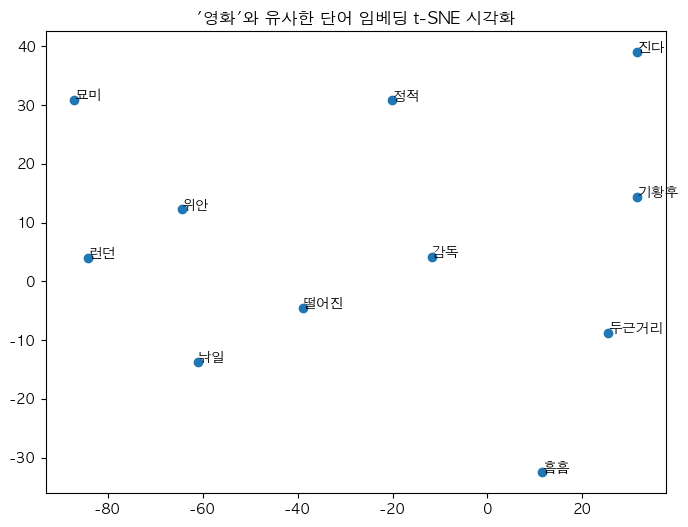

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

# 1. 유사한 단어 top-N 추출
def most_similar(word, embedding_weights, word_to_index, topn=10):
    idx = word_to_index.get(word)
    if idx is None:
        return []
    vec = embedding_weights[idx].reshape(1, -1)
    sims = cosine_similarity(vec, embedding_weights)[0]
    top_indices = np.argsort(sims)[::-1][1:topn+1]
    index_to_word = {idx: word for word, idx in word_to_index.items()}
    return [(index_to_word[i], sims[i]) for i in top_indices]

# 예시: '영화'와 유사한 단어 10개
similar_words = most_similar('감독', embeddings, word_to_index, topn=10)
words = ['감독'] + [w for w, _ in similar_words]
indices = [word_to_index[w] for w in words]

# 2. 해당 단어 임베딩만 추출 후 t-SNE 시각화
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced = tsne.fit_transform(embeddings[indices])

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, (reduced[i, 0], reduced[i, 1]))
plt.title("'영화'와 유사한 단어 임베딩 t-SNE 시각화")
plt.show()


In [30]:
# 한국어 word2vec 임베딩 활용하여 성능 개선
# 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
# 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 참고 링크1, 참고 링크2
# from gensim.models import KeyedVectors
# 한국어 Word2Vec 모델 로드
# word2vec_model = KeyedVectors.load('data/word2vec_ko.model')
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load('data/word2vec_ko.model')
vector = word_vectors.wv['끝']

# 한국어 word2vec 임베딩을 PyTorch 모델에 적용
embedding_dim = word_vectors.vector_size
vocab_size = len(word_to_index)
embedding_weights = np.zeros((vocab_size, embedding_dim))
for word, idx in word_to_index.items():
    if word in word_vectors.wv:
        embedding_weights[idx] = word_vectors.wv[word]
    else:
        embedding_weights[idx] = np.random.normal(size=(embedding_dim,))   
embedding_weights = torch.tensor(embedding_weights, dtype=torch.float32)

# 모델을 Word2Vec 임베딩 차원에 맞게 새로 생성
models = {
    'LSTM': LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim),
    '1D_CNN': CNNModel(vocab_size, embedding_dim, output_dim),
    'GlobalMaxPooling': GlobalMaxPoolingModel(vocab_size, embedding_dim, output_dim)
}

# 모델에 임베딩 가중치 적용
for name, model in models.items():
    if hasattr(model, 'embedding'):
        model.embedding.weight.data.copy_(embedding_weights)

# 모델 재학습 및 평가
for name, model in models.items():
    print(f'--- {name} 모델 학습 및 평가 (Word2Vec 임베딩 적용) ---')
    test_accuracy, train_losses, val_accuracies, embeddings = train_and_evaluate(
        model, train_loader, val_loader, test_loader, num_epochs, device
    )
    results[name] = test_accuracy
    all_train_losses[name] = train_losses
    all_val_accuracies[name] = val_accuracies
    print(f'{name} 모델 테스트 정확도: {test_accuracy:.4f}') 

--- LSTM 모델 학습 및 평가 (Word2Vec 임베딩 적용) ---
Epoch [1/20], Loss: 0.6435, Val Accuracy: 0.7123
Epoch [2/20], Loss: 0.4943, Val Accuracy: 0.7997
Epoch [3/20], Loss: 0.4092, Val Accuracy: 0.8202
Epoch [4/20], Loss: 0.3710, Val Accuracy: 0.8298
Epoch [5/20], Loss: 0.3461, Val Accuracy: 0.8337
Epoch [6/20], Loss: 0.3271, Val Accuracy: 0.8367
Epoch [7/20], Loss: 0.3132, Val Accuracy: 0.8385
Epoch [8/20], Loss: 0.3004, Val Accuracy: 0.8391
Epoch [9/20], Loss: 0.2890, Val Accuracy: 0.8391
Epoch [10/20], Loss: 0.2796, Val Accuracy: 0.8395
Epoch [11/20], Loss: 0.2711, Val Accuracy: 0.8394
Epoch [12/20], Loss: 0.2621, Val Accuracy: 0.8389
Epoch [13/20], Loss: 0.2546, Val Accuracy: 0.8402
Epoch [14/20], Loss: 0.2478, Val Accuracy: 0.8400
Epoch [15/20], Loss: 0.2413, Val Accuracy: 0.8403
Epoch [16/20], Loss: 0.2350, Val Accuracy: 0.8395
Epoch [17/20], Loss: 0.2294, Val Accuracy: 0.8378
Epoch [18/20], Loss: 0.2236, Val Accuracy: 0.8384
Epoch [19/20], Loss: 0.2183, Val Accuracy: 0.8384
Epoch [20/20], Lo

### 오늘의 회고
- 지난주에 얼추 와꾸 잡아놓고 좀 더 해보려고 했는데, 못해서 지금보니까 잘 기억이 안난다.
- CNN이 이미지에만 쓰는줄 알았더니 1D_CNN은 그래도 LSTM에 뒤지지 않는게 신기하다. 오히려 병렬처리가 되서 더 빠른거 같기도 하고
- 패딩이 pre, post가 차이 난다고 lms에 써있었는데 실제로 실험을 해보니 차이가 나는게 확연히 보여서 신기하긴 했다.
- 전에는 mps가속을 로컬에서 잘 안쓰고 예제대로 했는데 너무 느려서 적용가능한 부분에 다 적용해봤는데 훨씬 빨라서 여러가지 실험을 해보기 좋았다.